# Import Model

In [68]:
import ROOT
from array import array
import optparse
import numba as nb
import awkward as ak
import vector
import numpy as np
from torch import nn
from itertools import combinations, permutations
import uproot
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import h5py
import os, time, argparse, matplotlib, sklearn, torch, torchmetrics
#matplotlib.use('Agg') # Fix for $> _tkinter.TclError: couldn't connect to display "localhost:36.0"
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics import PrecisionRecallCurve, Accuracy, Precision, Recall, ROC

skimstore_place = "skim_root/"
h5py_place      = "dataframe/"
output_place    = "MergeOutput/"

## Class: Dataset

In [32]:
class custom_train_dataset(Dataset):
    def __init__(self, df, input_columns, target_column, transform=None, target_transform=None, device='cpu'):
        self.df = df
        # make tensors for values of inputs and relveant labels
        source_combs = self.df[input_columns].values
        target_labels = self.df[target_column].values
        self.x_train = torch.tensor(source_combs,dtype=torch.float32, device=torch.device(device))
        self.y_train = torch.tensor(target_labels,dtype=torch.float32, device=torch.device(device))
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        x_ = self.x_train[index]
        y_ = self.y_train[index]

        if self.transform:
            x_ = self.transform(x_)

        return x_, y_

## Class: Neural Network structure

In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self,nvars):
        # return a temporary object of superclass so we can call superclass' methods
        super(NeuralNetwork, self).__init__()
        # Initialise layers
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(), #Flattens contiguous range of dimensions into a tensor
            nn.Linear(nvars,24),
            nn.ReLU(),
            nn.Linear(24,12),
            nn.ReLU(),
            nn.Linear(12,8),
            nn.ReLU(),
            nn.Linear(8,4),
            nn.ReLU(),
            nn.Linear(4,1),
        )
    # Method to implement operations on input data
    # Passing input data to model automatically executes models forward method
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

## Parameter setting

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fin_name = 'ttc_a_200-700GeV_with_geninfo'
print('device',device)

device cuda


## Reading dataframe

In [35]:
df = []

# Scan target file
FileList = os.listdir(h5py_place)
for f in FileList:
    if (fin_name in f and 'h5' in f):
        df_ = pd.read_hdf(os.path.join(h5py_place,f))
        df.append(df_)
# Prepare dataframe
df = pd.concat(df)

# Data Preprocessing
colnames = list(df.keys())
ct = ColumnTransformer(
 [('StandardScaler', StandardScaler(), colnames[5:-3] )],
      remainder='drop'# Drop nontransformed columns
  )
index_ = df[colnames[:5]]
label_ = df[colnames[-3]]
label_pair_ = df[colnames[-2]]
label_valid_ = df[colnames[-1]]
result_ = ct.fit_transform(df)
result_ = np.c_[index_, result_, label_, label_pair_, label_valid_]
transformed_df = pd.DataFrame(result_,columns=colnames)
transformed_df = transformed_df.astype({'Entry':"int",'bmatched_jet_index':'int','lmatched_jet_index':'int','jet3_index':'int','jet4_index':'int','label':'int', 'label_pair':'int', 'label_valid':'int'})
transformed_df.to_hdf(os.path.join(output_place,fin_name + '.h5'),'df',mode='w',format='table',data_columns=True)


## Training

### Parameter

In [58]:
learning_rate = 0.00001
batchsize = 500
n_epochs = 450
input_columns_ = [
    'bmatched_jet_pt','bmatched_jet_eta','bmatched_jet_phi','bmatched_jet_mass', 'bmatched_jet_CvB', 'bmatched_jet_CvL', 'bmatched_jet_FlavB',
    'lmatched_jet_pt','lmatched_jet_eta','lmatched_jet_phi','lmatched_jet_mass', 'lmatched_jet_CvB', 'lmatched_jet_CvL', 'lmatched_jet_FlavB',
    'dR_bmatched_lmatched_jets','dR_bmatched_jet_lep1','dR_bmatched_jet_lep2','dR_lmatched_jet_lep1','dR_lmatched_jet_lep2',
    'invmass_bjlj',
    'lep1_pt','lep1_eta','lep1_phi','lep1_mass',
    'lep2_pt','lep2_eta','lep2_phi','lep2_mass',
    'jet3_pt','jet3_eta','jet3_phi','jet3_mass', 'jet3_CvB', 'jet3_CvL', 'jet3_FlavB',
    'jet4_pt','jet4_eta','jet4_phi','jet4_mass', 'jet4_CvB', 'jet4_CvL', 'jet4_FlavB'    
  ]

### Loop

In [59]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set (averaged batch loss * batch size) to 0
    batch_loss = 0.0
    # For each batch in the dataloader
    for batch, (X,y) in enumerate(dataloader):
        # Set any learned gradients for optimised tensors to zero (as they will otherwise be from previous batch using different parameters)
        optimizer.zero_grad()
        # Alter dimensions of labels tensor
        y = y.unsqueeze(1)
        # Compute prediction and loss for the whole batch
        logits = model(X)
        # Loss computation for the batch
        loss = loss_fn(logits, y)
        ### Backpropagation ###
        # compute sum of gradients of given tensor for this batch
        loss.backward()
        # Update weights
        optimizer.step()
        # Add loss to batch loss
        batch_loss += loss.item() * X.size(0)
        # Report every X batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch*len(X)
        #    print(f'loss:{loss:.4} [{current}/{size}]')
    # Return: averaged batch loss * batch size , model
    return batch_loss, model

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    batch_loss = 0.0
    # gradient calculation disabled (not needed in evaluation)
    with torch.no_grad():
        # for each batch
        for X,y in dataloader:
            # make prediction using model
            logits = model(X)
            y = y.unsqueeze(1) # required to ensure same dimensions
            # add loss for example to batch loss using prediction and ground truth
            test_loss = loss_fn(logits, y)
            # Add loss to batch loss
            batch_loss += test_loss.item() * X.size(0)
            # Report every X batches
            #if batch % 10 == 0:
            #    loss, current = test_loss.item(), batch*len(X)
            #    print(f'test_loss:{test_loss:.4} [{current}/{size}]')

        return batch_loss

def eval_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0
    # gradient calculation disabled (not needed in evaluation)
    with torch.no_grad():
        #pr_curve = PrecisionRecallCurve(pos_label=1)
        #roc = ROC(pos_label=1)
        all_truth_labels = []
        all_predictions = []

        # for each batch
        for X,y in dataloader:
            # make prediction using model
            logits = model(X)
            y = y.unsqueeze(1) # required to ensure same dimensions
            all_truth_labels += y.tolist()
            all_predictions += torch.sigmoid(logits).tolist()
            # add loss for example to batch loss using prediction and ground truth
            test_loss += loss_fn(logits, y).item()
            # pair predictions with data truth
            test_stack = torch.stack((torch.sigmoid(logits), y), dim=1)

        #print('New event\n',list(zip(all_predictions,all_truth_labels)))
        # Look for combination with highest prediciton score
        max_pred_ = max(all_predictions)
        # get the index of this combination
        max_pred_index_ = all_predictions.index(max_pred_)
        # Look for combination with highest truth label (i.e. == 1)
        max_truth_ = max(all_truth_labels)
        # Get the index
        max_truth_index_ = all_truth_labels.index(max_truth_)
        #print( 'predicted index: %s, truth index: %s' % (max_pred_index_, max_truth_index_) )
        return max_pred_index_, max_truth_index_


### Create dataset

In [69]:
# Create datasets
transformed_df = transformed_df[transformed_df['label_valid']==1]
train_df, test_df = train_test_split(transformed_df, test_size=0.2, shuffle=False)
test_df, val_df = train_test_split(test_df, test_size=0.5, shuffle=False)

train_dataset = custom_train_dataset(train_df, input_columns_, 'label_pair', device=device)
test_dataset  = custom_train_dataset(test_df, input_columns_, 'label_pair', device=device)
valid_dataset = custom_train_dataset(val_df, input_columns_, 'label_pair', device=device)

# DataLoaders for train datasets
training_data_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
testing_data_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

# Test dataLoaders by loading batches of features and labels
train_features, train_labels = next(iter(training_data_loader))
print(f"Features batch shape: {train_features.size()} ")
print(f"Labels batch shape: {train_labels.size()} ")

# Class weights
# Be careful using class weights:
#       - Too large and they can cause instability in the training such that the algorithm doesnt learn
#       - Too small and if you have class imbalance, class(es) can be ignored to obtain high accuracy
n_sig = [x for x in train_labels if x == 1]
n_bkg = [x for x in train_labels if x == 0]
class_ratio = len(n_bkg)/len(n_sig)
print('sig/bkg class ratio: ', class_ratio)

Features batch shape: torch.Size([500, 42]) 
Labels batch shape: torch.Size([500]) 
sig/bkg class ratio:  5.944444444444445


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=42, out_features=24, bias=True)
    (2): ReLU()
    (3): Linear(in_features=24, out_features=12, bias=True)
    (4): ReLU()
    (5): Linear(in_features=12, out_features=8, bias=True)
    (6): ReLU()
    (7): Linear(in_features=8, out_features=4, bias=True)
    (8): ReLU()
    (9): Linear(in_features=4, out_features=1, bias=True)
  )
)


  0%|          | 0/450 [00:00<?, ?it/s]

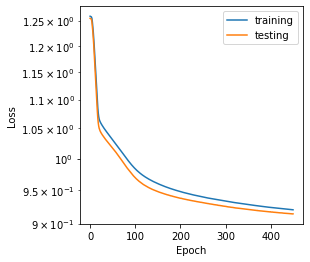

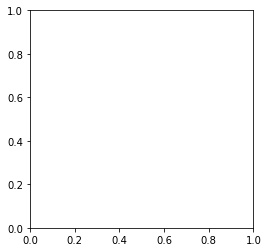

In [61]:
loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_ratio))
#loss_function = nn.BCEWithLogitsLoss()

model = NeuralNetwork(len(input_columns_)).to(device)
print(model)

# Initialsed optimiser with models parameters
# n.b. must call parameters method on model when initialising optimiser
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

# Looping over entire dataset
train_losses = []
test_losses = []
iters = 0

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
import tqdm
epochs = tqdm.notebook.trange(n_epochs)
from IPython import display
dh = display.display(fig, display_id=True)

for epoch in epochs:
    loss_ , model_ = train_loop(training_data_loader, model, loss_function, optimizer)
    test_loss_ = test_loop(testing_data_loader, model, loss_function)
    # Calculate the average loss over the epoch
    av_training_loss = loss_/len(training_data_loader.sampler)
    av_testing_loss = test_loss_/len(testing_data_loader.sampler)
    epochs.set_description('Average Loss: {:5f}(Train) {:5f}(Test)'.format(av_training_loss, av_testing_loss))
    train_losses.append(av_training_loss)
    test_losses.append(av_testing_loss)

    model_outdir_name = 'model_'+str(learning_rate)+'_'+str(batchsize)+'_'+str(n_epochs)
    if not os.path.isdir(model_outdir_name):
            print('Making model directory: ', model_outdir_name)
            os.makedirs(model_outdir_name)
    model_save_ = os.path.join(model_outdir_name,'saved_model.pt')
    torch.save(model_.state_dict(), model_save_)

    fig, ax = plt.subplots(ncols=1, figsize=(4,4))
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, label='testing')
    plt.legend(loc='upper right')
    dh.update(fig)
    plt.close(fig)

## Application (Validation)

In [70]:
print('Evaluation on ', device)
groups_ = val_df.groupby('Entry')
num_corr_ptSel = 0
num_corr = 0
total_ = 0

def pT_rank_sel(test_dataset):
    sum_pt_ = -100
    for row in test_dataset.index:
        if test_dataset['bmatched_jet_pt'][row] < test_dataset['lmatched_jet_pt'][row]: continue
        if test_dataset['bmatched_jet_pt'][row] + test_dataset['lmatched_jet_pt'][row] > sum_pt_:
            sum_pt_ = test_dataset['bmatched_jet_pt'][row] + test_dataset['lmatched_jet_pt'][row]
            label_pT_high = test_dataset['label_pair'][row]

    return label_pT_high

for evnum in groups_.groups.keys():
    val_dataset = custom_train_dataset(groups_.get_group(evnum), input_columns_, 'label_pair', device=device)
    val_data_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    max_pred_idx , corr_idx_ = eval_loop(val_data_loader, model, loss_function)
    label_high_pt_sel = pT_rank_sel(groups_.get_group(evnum))

    total_ += 1
    if label_high_pt_sel == 1:
        num_corr_ptSel+=1
    if max_pred_idx == corr_idx_:
        num_corr+=1
percent_corr_ptSel = (num_corr_ptSel/total_)*100
percent_corr = (num_corr/total_)*100
print(f'{num_corr}/{total_} ({percent_corr:.3} percent) events correctly assigned by algo')
print(f'{num_corr_ptSel}/{total_} ({percent_corr_ptSel:.3} percent) events correctly assigned by selecting high-pt pair')
with open(os.path.join(model_outdir_name,'results.txt'), 'w') as f:
        lines =[f'{num_corr}/{total_} ({percent_corr:.3} percent) events correctly assigned by algo', f'{num_corr_ptSel}/{total_} ({percent_corr_ptSel:.3} percent) events correctly assigned by selecting high-pt pair']
        f.write('\n'.join(lines))
print('FIN!')

Evaluation on  cuda


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [71]:
# Load DNN 
model = NeuralNetwork(len(input_columns_))
model.load_state_dict(torch.load('model_1e-05_500_450/saved_model.pt'))
model.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=42, out_features=24, bias=True)
    (2): ReLU()
    (3): Linear(in_features=24, out_features=12, bias=True)
    (4): ReLU()
    (5): Linear(in_features=12, out_features=8, bias=True)
    (6): ReLU()
    (7): Linear(in_features=8, out_features=4, bias=True)
    (8): ReLU()
    (9): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [72]:
source_combs = val_df[input_columns_].values
X_input      = torch.tensor(source_combs, dtype=torch.float32)
predicted    = torch.sigmoid(model(X_input)).detach().numpy()
predicted    = np.array(predicted.reshape(len(predicted)))
val_df_copy  = val_df
val_df_copy.insert(1, "predicted", predicted)
idx = val_df_copy.groupby(['Entry'])['predicted'].transform(max) == val_df_copy['predicted']
df = val_df_copy[idx]

In [73]:
idx_1 = val_df.groupby(['Entry'])['bmatched_jet_index'].transform(min) == val_df['bmatched_jet_index']
df1 = val_df[idx_1]
idx_2 = df1.groupby(['Entry'])['lmatched_jet_index'].transform(min) == df1['lmatched_jet_index']
df2 = df1[idx_2]
idx_3 = df2.groupby(['Entry'])['jet3_index'].transform(min) == df2['jet3_index']
df3 = df2[idx_3]
idx_4 = df3.groupby(['Entry'])['jet4_index'].transform(min) == df3['jet4_index']
df_order = df3[idx_4]

In [74]:
df_well_match = df[df['label_valid'] == 1]
df_bad_match  = df[df['label_valid'] == 0]
df_well_match_order = df_order[df_order['label_valid'] == 1]
df_bad_match_order  = df_order[df_order['label_valid'] == 0]

In [75]:
print("ratio of well matching: ", len(df_well_match)/len(df))
print("----- well match (order) -----")
print("accuracy: %.4f"%(df_well_match['label'].sum()/len(df_well_match)))
print("accuracy(pt order): %.4f"%(df_well_match_order['label'].sum()/len(df_well_match_order)))
print("----- well match (pair) -----")
print("accuracy: %.4f"%(df_well_match['label_pair'].sum()/len(df_well_match)))
print("accuracy(pt order): %.4f"%(df_well_match_order['label_pair'].sum()/len(df_well_match_order)))

ratio of well matching:  1.0
----- well match (order) -----
accuracy: 0.2363
accuracy(pt order): 0.1465
----- well match (pair) -----
accuracy: 0.4604
accuracy(pt order): 0.3966


In [17]:
def invariant_mass(pt1: pd.Series,
                   eta1: pd.Series,
                   phi1: pd.Series,
                   mass1: pd.Series,
                   pt2: pd.Series,
                   eta2: pd.Series,
                   phi2: pd.Series,
                   mass2: pd.Series) -> pd.Series:
    v1 = vector.obj(pt=pt1, eta=eta1, phi=phi1, mass=mass1)
    v2 = vector.obj(pt=pt2, eta=eta2, phi=phi2, mass=mass2)

    return (v1+v2).mass
def pt_sum(pt1: pd.Series,
           pt2: pd.Series) -> pd.Series:
    return pt1 + pt2

In [18]:
inv_mass = df_well_match.apply(lambda row: invariant_mass(row["bmatched_jet_pt"],
                                                          row["bmatched_jet_eta"], 
                                                          row["bmatched_jet_phi"],
                                                          row["bmatched_jet_mass"],
                                                          row["lmatched_jet_pt"],
                                                          row["lmatched_jet_eta"],
                                                          row["lmatched_jet_phi"],
                                                          row["lmatched_jet_mass"]), axis =1)